# Práctica Final Aprendizaje Automático

Grupo 5: Jorge Ortega y Daniela Vidal

## Índice

1. [Presentación del dataset](#Presentación-del-dataset)
2. [Preprocesamiento](#Preprocesamiento)
3. [Dataset final](#Dataset-final)
4. [Separación en entrenamiento, validación y test](#Separación-en-entrenamiento,-validación-y-test)
5. [Regresión logística](#Reg-logística)
6. [Red neuronal](#Red-neuronal)
7. [Árboles de decisión](#Árboles-de-decisión)
8. [Comparación de resultados](#Comparación-de-resultados)
9. [Conclusiones](#Conclusiones)
10. [Bibliografía](#Bibliografía) 

## 1. Presentación del dataset <a class="anchor" id="Presentación-del-dataset"></a>

Esta práctica consiste en la aplicación de los conocimientos adquiridos en la asignatura de Aprendizaje Automático a un dataset sobre reconocimiento de gestos con datos de la actividad muscular. Lo que se pretende es realizar un clasificador que sea capaz de predecir qué gesto se está realizando a partir de los datos de la actividad muscular.

El dataset que hemos elegido para realizar la práctica es el de [Classify gestures by reading muscle activity](https://www.kaggle.com/datasets/kyr7plus/emg-4). Se trata de un dataset de Kaggle que contiene datos de la actividad muscular de 4 gestos diferentes: 
- Piedra (puño)

- Papel (extensión de la mano)

- Tijeras (dedos índice y corazón extendidos)

- Okay (dedo índice tocando el pulgar y el resto de dedos extendidos). 

Los datos se han recogido con señales EMG (electromiografía). Las señales EMG son señales eléctricas que se producen en los músculos cuando estos se activan y se pueden utilizar para detectar y clasificar gestos. Los datos se han recogido con una banda colocada en el brazo con 8 sensores en la superficie de la piel, cada uno de ellos recoge la actividad eléctrica producida por los músculos debajo de la piel. 
Cada línea del dataset consiste en 40ms en las que se hacen 8 medidas consecutivas de los 8 sensores, es decir, 64 columnas en total de esta manera:

                                    [8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][8 sensores][Gesto]

En total hay 120s de cada gesto.

La columna 'Gesto' clasifica piedra - 0, tijeras - 1, papel - 2, okay - 3.

Para asegurarse de la calidad de los datos, se realizaron 6 repeticiones de cada gesto en la que se empezaba y se paraba de medir con el gesto sostenido.

Se trata de 4 datasets de alrededor de 2900 filas cada uno con la actividad de cada gesto. 

## 2. Preprocesamiento <a class="anchor" id="Preprocesamiento"></a>

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import seaborn as sns

### Constantes globales

In [58]:
RANDOM_STATE = 42

### Lectura del dataset

In [59]:
X0 = pd.read_csv('0.csv')
X1 = pd.read_csv('1.csv')
X2 = pd.read_csv('2.csv')
X3 = pd.read_csv('3.csv')

Podemos ver lo que contienen los datasets en las siguientes tablas:

In [60]:
X0.head()

,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0.3,8.0.1,5.0.1,4.0.4,-7.0.1,-59.0,16.0,0
0,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
1,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
2,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
3,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0
4,15.0,-5.0,-5.0,-15.0,12.0,-22.0,-38.0,36.0,9.0,6.0,...,-26.0,5.0,6.0,6.0,11.0,5.0,30.0,-48.0,25.0,0


In [61]:
X1.head()

,-7.0,-1.0,-1.0.1,0.0,-10.0,-10.0.1,-1.0.2,1.0,-5.0,-5.0.1,...,6.0.1,-4.0.6,-3.0.5,-5.0.5,-3.0.6,15.0.1,11.0,-4.0.7,-5.0.6,1
0,-6.0,-2.0,-5.0,-2.0,27.0,42.0,3.0,5.0,11.0,1.0,...,2.0,-17.0,-5.0,-7.0,-2.0,15.0,12.0,0.0,-7.0,1
1,5.0,0.0,-1.0,-2.0,2.0,-9.0,1.0,5.0,1.0,-3.0,...,-11.0,-23.0,1.0,-1.0,-1.0,-23.0,-25.0,2.0,-1.0,1
2,31.0,4.0,2.0,-2.0,38.0,14.0,2.0,7.0,-2.0,4.0,...,-4.0,13.0,2.0,-1.0,-3.0,-7.0,0.0,-3.0,-2.0,1
3,-4.0,-4.0,3.0,3.0,-25.0,-46.0,-1.0,3.0,-7.0,-6.0,...,15.0,4.0,-4.0,-1.0,-1.0,7.0,26.0,3.0,-7.0,1
4,-8.0,-3.0,-1.0,0.0,14.0,5.0,-4.0,-6.0,2.0,0.0,...,-18.0,53.0,8.0,-1.0,-1.0,-2.0,-5.0,-2.0,9.0,1


In [62]:
X2.head()

,4.0,19.0,-9.0,-7.0,-3.0,-36.0,-6.0,-23.0,3.0,-21.0,...,9.0,-14.0.1,-2.0.5,-3.0.3,-4.0,-21.0.1,7.0,-8.0.1,-12.0.2,2
0,-1.0,12.0,20.0,7.0,20.0,-73.0,-4.0,-2.0,4.0,5.0,...,-3.0,-5.0,-2.0,0.0,-4.0,-7.0,5.0,6.0,9.0,2
1,4.0,5.0,-8.0,-2.0,10.0,-10.0,-10.0,16.0,-3.0,-18.0,...,2.0,0.0,2.0,3.0,-8.0,19.0,20.0,0.0,-8.0,2
2,-3.0,-3.0,5.0,11.0,25.0,-20.0,-2.0,14.0,9.0,32.0,...,15.0,-2.0,16.0,6.0,9.0,1.0,31.0,16.0,4.0,2
3,-5.0,-9.0,-2.0,-5.0,-46.0,-34.0,-9.0,-4.0,0.0,8.0,...,-5.0,-11.0,-6.0,7.0,6.0,-10.0,-24.0,-6.0,0.0,2
4,3.0,-3.0,-6.0,-5.0,-3.0,-4.0,-5.0,-4.0,-5.0,8.0,...,-18.0,-14.0,8.0,1.0,-2.0,-4.0,-34.0,-3.0,6.0,2


In [63]:
X3.head()

,-22.0,-9.0,-6.0,-1.0,21.0,26.0,-2.0,5.0,5.0.1,0.0,...,-10.0,-15.0.1,-6.0.3,-3.0.4,3.0.1,20.0,25.0,1.0.5,1.0.6,3
0,-7.0,0.0,1.0,0.0,-13.0,-18.0,0.0,-9.0,-6.0,-2.0,...,-1.0,11.0,-4.0,-5.0,-4.0,3.0,-8.0,-7.0,-3.0,3
1,-6.0,-6.0,-6.0,-8.0,25.0,43.0,-4.0,7.0,6.0,1.0,...,3.0,2.0,1.0,3.0,-1.0,1.0,9.0,4.0,4.0,3
2,2.0,1.0,1.0,1.0,0.0,-23.0,2.0,-6.0,-1.0,-2.0,...,16.0,-3.0,-1.0,-1.0,-3.0,0.0,-3.0,4.0,3.0,3
3,0.0,3.0,4.0,5.0,1.0,25.0,-9.0,0.0,0.0,1.0,...,1.0,6.0,2.0,1.0,-3.0,-20.0,-42.0,-4.0,2.0,3
4,-11.0,-2.0,-5.0,1.0,-7.0,-11.0,-4.0,-23.0,-9.0,0.0,...,-4.0,9.0,1.0,2.0,8.0,21.0,41.0,15.0,9.0,3


Como habíamos comentado, cada dataset tiene 2900 filas, 8 columnas de sensores y una columna de gesto. En este caso, los gestos están codificados como 0, 1, 2 y 3 para piedra, tijeras, papel y okay respectivamente. En el resto de columnas podemos ver datos numéricos que representan la actividad muscular en cada sensor.

In [64]:
print(X0.shape, X1.shape, X2.shape, X3.shape)

(2909, 65) (2902, 65) (2942, 65) (2921, 65)


Como podemos hay más o menos el mismo número de gestos de cada tipo y el mismo número de medidas. Igualmente nos encargaremos del desbalanceo de clases para obtener mejores resultados.

A continuación vamos a comprobar si para cada archivo está correctamente clasificada su clase:

In [65]:
X0.iloc[:,-1].value_counts(), X1.iloc[:,-1].value_counts(), X2.iloc[:,-1].value_counts(), X3.iloc[:,-1].value_counts()

(0    2909
 Name: 0, dtype: int64,
 1    2902
 Name: 1, dtype: int64,
 2    2942
 Name: 2, dtype: int64,
 3    2921
 Name: 3, dtype: int64)

Comprobaremos también que no hay valores nulos en los datasets:

In [66]:
X0.isna().sum().sum(), X1.isna().sum().sum(), X2.isna().sum().sum(), X3.isna().sum().sum()

(0, 0, 0, 0)

Ahora que hemos comprobado que los datos están bien clasificados y no hay valores nulos, vamos a unir los 4 datasets en uno solo para poder trabajar con todos los datos a la vez:

In [67]:
allFiles=['0.csv','1.csv','2.csv','3.csv']

list = []
for file in allFiles:
    read = pd.read_csv(file, header = None)
    list.append(read)
data = pd.concat(list)


In [68]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,26.0,4.0,5.0,8.0,-1.0,-13.0,-109.0,-66.0,-9.0,2.0,...,-28.0,61.0,4.0,8.0,5.0,4.0,-7.0,-59.0,16.0,0
1,-47.0,-6.0,-5.0,-7.0,13.0,-1.0,35.0,-10.0,10.0,-4.0,...,-25.0,47.0,6.0,6.0,5.0,13.0,21.0,111.0,15.0,0
2,-19.0,-8.0,-8.0,-8.0,-21.0,-6.0,-79.0,12.0,0.0,5.0,...,-83.0,7.0,7.0,1.0,-8.0,7.0,21.0,114.0,48.0,0
3,2.0,3.0,0.0,2.0,0.0,22.0,106.0,-14.0,-16.0,-2.0,...,-38.0,-11.0,4.0,7.0,11.0,33.0,39.0,119.0,43.0,0
4,6.0,0.0,0.0,-2.0,-14.0,10.0,-51.0,5.0,7.0,0.0,...,38.0,-35.0,-8.0,2.0,6.0,-13.0,-24.0,-112.0,-69.0,0


Por otro lado podemos ver como los rangos de los datos son relativamente diferentes, por lo que tendremos que normalizarlos para que no haya problemas a la hora de entrenar los modelos.

In [69]:
def min_max_scale(X):
    x = X.iloc[:, :-1].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled, columns=X.columns[:-1]) #La columna de la clase no se escala
    df_scaled[X.columns[-1]] = X[X.columns[-1]].values
    return df_scaled

In [70]:
X_scal = min_max_scale(data)

## 3. Dataset final <a class="anchor" id="Dataset-final"></a>

El dataset final que vamos a utilizar para entrenar los modelos es el siguiente:

In [71]:
X_scal.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.625551,0.556701,0.567164,0.638462,0.563380,0.437751,0.074510,0.244094,0.426160,0.555556,...,0.413223,0.728395,0.566524,0.720000,0.632,0.502347,0.474510,0.270588,0.557769,0
1,0.303965,0.505155,0.417910,0.523077,0.629108,0.485944,0.639216,0.464567,0.506329,0.529915,...,0.425620,0.670782,0.575107,0.693333,0.632,0.544601,0.584314,0.937255,0.553785,0
2,0.427313,0.494845,0.373134,0.515385,0.469484,0.465863,0.192157,0.551181,0.464135,0.568376,...,0.185950,0.506173,0.579399,0.626667,0.528,0.516432,0.584314,0.949020,0.685259,0
3,0.519824,0.551546,0.492537,0.592308,0.568075,0.578313,0.917647,0.448819,0.396624,0.538462,...,0.371901,0.432099,0.566524,0.706667,0.680,0.638498,0.654902,0.968627,0.665339,0
4,0.537445,0.536082,0.492537,0.561538,0.502347,0.530120,0.301961,0.523622,0.493671,0.547009,...,0.685950,0.333333,0.515021,0.640000,0.640,0.422535,0.407843,0.062745,0.219124,0


In [72]:
X_scal.shape

(11678, 65)

Es decir 11678 filas y 65 columnas.

In [73]:
X_scal.iloc[:,-1].value_counts()

2    2943
3    2922
0    2910
1    2903
Name: 64, dtype: int64

## 4. Separación en entrenamiento, validación y test <a class="anchor" id="Separación-en-entrenamiento,-validación-y-test"></a>

Deberemos dividir de manera distinta para los modelos de clasificación y los de regresión. Para los modelos de clasificación, dividiremos en entrenamiento, validación y test, mientras que para los de regresión, dividiremos en entrenamiento y test. Además para el de regresión usaremos dos el dataset de piedra y el de papel de manera que haya dos posibles salidas y podamos aplicar la función sigmoide para calcular la probabilidad de que sea una u otra, mientras que para el de clasificación usaremos todos los gestos.

#### Regresión

Primero sacaremos los datos de piedra y papel para el modelo de regresión:

In [74]:
allFiles=['0.csv','1.csv']

list = []
for file in allFiles:
    read = pd.read_csv(file, header = None)
    list.append(read)
data_reg = pd.concat(list)

Los normalizamos:

In [75]:
X_reg_scal = min_max_scale(data_reg)

In [76]:
X_R = X_reg_scal.iloc[:, :-1].values
y_R = X_reg_scal.iloc[:, -1].values

Y los dividimos en entrenamiento y test (80-20):

In [77]:
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_R, y_R, test_size=0.2, random_state=RANDOM_STATE, stratify=y_R)

In [78]:
X_trainR.shape, X_testR.shape

((4650, 64), (1163, 64))

#### Clasificación

Dividiremos en 60-20-20 para entrenamiento, test y validación. Aunque las clases están balanceadas, utilizaremos la función de sklearn para asegurarnos de que se mantienen las proporciones de cada clase en cada conjunto.

In [79]:
X_train, X, y_train, y = train_test_split(X_scal.iloc[:, :-1], X_scal.iloc[:, -1],test_size=0.4, random_state=RANDOM_STATE, stratify=X_scal.iloc[:, -1])
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_STATE, stratify=y)

In [80]:
X_train.shape, X_val.shape, X_test.shape

((7006, 64), (2336, 64), (2336, 64))

## 5. Regresión logística <a class="anchor" id="Reg-logística"></a>

Primero estudiaremos los datos para ver cómo de fuerte es la correlación entre las variables, esto es la relación existente entre ellas, y si hay alguna que no aporta información. 

Para ello usaremos la matriz de correlación ya que son demasiados valores para verlos en una tabla:

<Axes: >

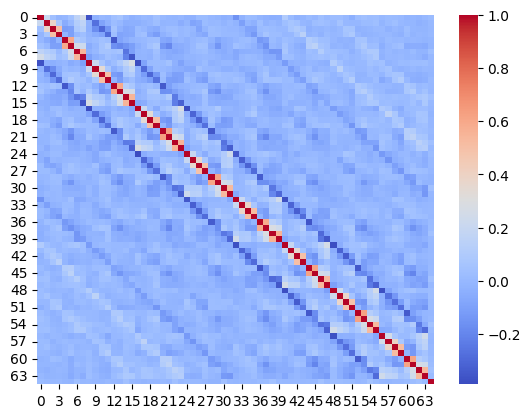

In [83]:
corr_matrix = X_reg_scal.corr()
corr_matrix.to_csv('corr_matrix.csv', index=False)
sns.heatmap(corr_matrix, cmap='coolwarm')

Podemos observar aquí que el único caso en el que tenemos un color rojo (1.0 en correlación) es en la diagonal lo cual es evidente ya que una variable está correlacionada consigo misma. Esto nos indica que no hay variables que estén fuertemente correlacionadas entre sí y que todas aportan información. La máxima correlación que tenemos es de 0.6 en menos de 10 variables (lo que se puede ver de color más clarito, esto se puede comprobar em corr_matrix.csv) pero en general se pueden ver colores más oscuros, lo cual indica que la correlación es baja. Debido a esto, al hacer regresión logística podemos esperar que el modelo obtenga resultados medios. Pero está claro que no es el mejor modelo para este dataset. 

#### Funciones necesarias para la regresión logística:

1. Cálculo de la función de coste y su gradiente

Definición de la función sigmoide a la que se le pasa el vector w, el valor de b y el vector x y se hace el producto escalar para calcular z.

In [ ]:
def func_sigmoide(x, w, b):
    z = np.dot(x,w)+b
    return 1/(1+np.exp(-z))

Función que devuelve la predicción según el modelo entrenado.

In [ ]:
def predict(X, Y, w, b):
   # XX = map_feature(X[:, 0], X[:, 1])
    y_hat= func_sigmoide(X, w, b)
    y_hat = np.where(y_hat >= 0.5, 1, 0)
    return y_hat

Función de coste regularizada: (siendo θ nuestro w,b)

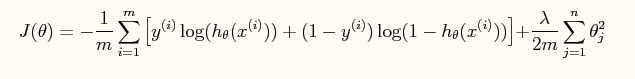

*Figura 1: Función de coste regularizada*

In [ ]:
def func_coste(X, Y, w, b, L):
    m = len(Y)
    f = func_sigmoide(X, w, b)
    coste = (-1/m)*np.sum(Y*np.log(f)+(1-Y)*np.log(1-f))
    coste += (L/(2*m))*np.sum(w**2)
    return coste

La función del cálculo de gradiente con regularización es:

Para w:

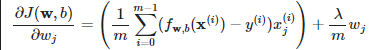

Para b:

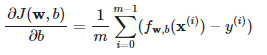

*Figuras 2 y 3: Gradiente de la función de coste regularizada*


In [ ]:
def funcion_grad(X, y, w, b, L):
    m = len(y)
    gw = np.zeros(w.shape)
    gb = 0
    y_hat = func_sigmoide(X, w, b)
    dif = y_hat-y
    
    gb = np.sum(dif)/m                                    
    gw = (1/m) * np.dot(dif,X) + L*w/m
    
    return gw, gb

In [ ]:
def funcion_grad_desc(X, y, w, b, alpha, num_iter, L):   
    for i in range(num_iter):
        gw, gb = funcion_grad(X, y, w, b, L)
        w = w - alpha*gw
        b = b - alpha*gb
    return w, b

2. Cálculo de los valores 

Haremos una regresión logística con regularización, para ello probaremos con diferentes valores de lambda y veremos cuál es el que mejor resultado nos da. 
Los valores que vamos a probar son:

Lambda: 0.1, 1, 2, 4, 6, 8, 10

En cuanto al valor de alpha hemos decidido dejarlo en 0.001 un valor lo suficientemente pequeño como para garantizar una solución sin que se pase.  

In [ ]:
def regresion_logistica(X, y, alpha, num_iter, L):
    w, b = funcion_grad_desc(X, y, np.zeros(X.shape[1]), 0, alpha, num_iter, L)
    return w, b

In [ ]:
Ls = [0.1, 1, 2, 4, 6, 8, 10]
train_acc = []
test_acc = []

for l in Ls:
    w, b = regresion_logistica(X_trainR, y_trainR, 0.001, 100000, l)
    print("Lambda: ", l)
    y_hat_train = predict(X_trainR, y_trainR, w, b)
    print("Accuracy: ", np.mean(y_hat_train == y_trainR)*100, "%")
    y_hat = predict(X_testR, y_testR, w, b)
    print("Accuracy: ", np.mean(y_hat == y_testR)*100, "%")
    
    train_acc.append(np.mean(y_hat_train == y_trainR)*100)
    test_acc.append(np.mean(y_hat == y_testR)*100)

4. Pintamos la curva de aprendizaje según los distintos valores de lambda:

In [ ]:
fig, ax = plt.subplots()

ax.plot(Ls , train_acc, label='Train Accuracy')
ax.plot(Ls , test_acc, label='Test Accuracy')

ax.set_xlabel('Lambda')
ax.set_ylabel('Accuracy')
ax.set_title('Aprendizaje según Lambda')

ax.legend()
plt.show()

# 6. Red neuronal multiclase <a class="anchor" id="Red-neuronal"></a> 

Vamos a desarrollar una red neuronal para clasificar los gestos. Exploraremos el proceso de construcción, entrenamiento y evaluación de una red neuronal multicapa. Para ello usaremos la librería Keras de Tensor Flow.

En este caso ya usaremos los cuatro gestos para entrenar el modelo cuyo objetivo es clasificarlo en uno de estos, por lo que usaremos el dataset de clasificación. 

Se trata de un problema de clasificación multiclase, por lo que usaremos:
- **Función de activación softmax** en la capa de salida. Esta función es una generalización de la función sigmoide para más de dos clases la cual devuelve un vector de probabilidades de que la entrada pertenezca a cada una de las clases (una distribución de probabilidad). 
- **Optimizador Adam**, el cual utiliza una tasa de aprendizaje adaptativa para cada parámetro en lugar de una global y que, además, es una buena opción por su eficiencia computacional y su capacidad para manejar problemas con muchos datos y parámetros. 
- La función de coste que usaremos será la **entropía cruzada categórica**, la cual es la más utilizada para problemas de clasificación multiclase.
- Por último, en las capas ocultas usaremos la función de **activación ReLU**, la cual es la más utilizada en redes neuronales ya que es muy eficiente computacionalmente.

Los datos de entrada son los valores de los sensores y la salida es un vector de 4 posiciones con la probabilidad de que la entrada pertenezca a cada una de las clases.

Estos datos están ya normalizados y divididos en entrenamiento, validación y test. Recordemos qué datos tenemos:

In [85]:
X_train.shape, X_val.shape, X_test.shape

((7006, 64), (2336, 64), (2336, 64))

En total tenemos 7006 datos de entrenamiento, 2336 de validación y 2336 de test. Además son 64 columnas, es decir, la cantidad de datos de entrenamiento es bastante alta, por lo que usaremos un modelo complejo con regularización.

Modelo con 150 unidades en la primera capa, 50 en la segunda y 4 en la de salida:

Probaremos con diferentes valores de lambda para ver cuál es el que mejor resultado nos da. Los valores que vamos a probar son:

## Ajuste

In [110]:
X_train.shape, X_val.shape, X_test.shape

((7006, 64), (2336, 64), (2336, 64))

In [118]:
lambdas = [0.001, 0.01, 0.1, 1]
iters = 1000

In [119]:
def parameter_decision(X_train, y_train, X_val, y_val, X_test, y_test, lambdas):
    acc = []
    inputs = tf.keras.Input(shape=(64,))
    for l in lambdas:
        x = tf.keras.layers.Dense(units=150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l))(inputs)
        x = tf.keras.layers.Dense(units=50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l))(x)
        outputs = tf.keras.layers.Dense(units=4, activation='softmax')(x)
        modelo = tf.keras.Model(inputs=inputs, outputs=outputs)
        modelo.compile(loss=SparseCategoricalCrossentropy(),
                       optimizer=Adam(learning_rate=1e-3))
        modelo.fit(X_train, y_train, epochs=iters, validation_data=(X_val, y_val), verbose=0)
        
        y_hat = modelo.predict(X_test)
        aux = np.mean(np.argmax(y_hat, axis=1) == y_test)
        
        acc.append(aux)
    return acc

In [120]:
acc = parameter_decision(X_train, y_train, X_val, y_val, X_test, y_test, lambdas)

73/73 [==============================] - 0s 2ms/step


Visualizamos los datos

[0.8762842465753424,
 0.2521404109589041,
 0.2521404109589041,
 0.2521404109589041]

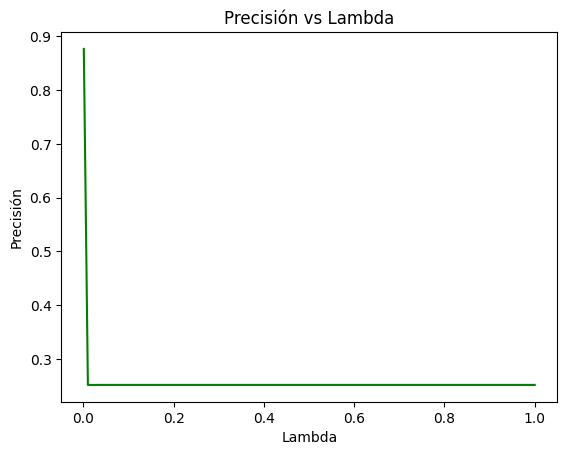

In [121]:
plt.plot(lambdas, acc, color="green")
plt.xlabel("Lambda")
plt.ylabel("Precisión")
plt.title("Precisión vs Lambda")
acc

En este caso el mejor resultado lo obtenemos para lambda:

In [122]:
best_lambda = lambdas[np.argmax(acc)]
best_lambda

0.001

## Red neuronal con mejor resultado:

In [125]:
inputs = tf.keras.Input(shape=(64,))
x = tf.keras.layers.Dense(units=150, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(best_lambda))(inputs)
x = tf.keras.layers.Dense(units=50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(best_lambda))(x)
outputs = tf.keras.layers.Dense(units=4, activation='softmax')(x)
modelo = tf.keras.Model(inputs=inputs, outputs=outputs)
modelo.compile(loss=SparseCategoricalCrossentropy(),
                optimizer=Adam(learning_rate=1e-3))
modelo.fit(X_train, y_train, epochs=iters, validation_data=(X_val, y_val), verbose=0)

73/73 [==============================] - 1s 5ms/step


In [127]:
y_hat = modelo.predict(X_test)
aux = np.mean(np.argmax(y_hat, axis=1) == y_test)
print("Precisión: ", aux*100, "%")

73/73 [==============================] - 1s 7ms/step
Precisión:  86.08732876712328 %


## Estudio de la precisión:


Primero veremos las medidas de calidad respecto a los datos de entrenamiento (métricas de entrenamiento):
- Precision: fracción de predicciones correctas que el modelo ha hecho
- Recall: fracción de ejemplos positivos que el modelo ha predicho correctamente
- F1-score: medida de la precisión y exhaustividad del modelo

In [129]:
cr = classification_report(y_test, y_hat, target_names=['0', '1', '2', '3'])
print (cr)

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

TODO conclusiones

Podemos ver también cómo de bien clasifica cada clase con la matriz de confusión:

In [ ]:
confussion_matrix = confusion_matrix(y_test, r_m_pred, labels= [0, 1, 2, 3])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Piedra', 'Papel', 'Tijera', 'Okay'])
cm_display.plot()
plt.show()

# 10. Bibiliografía <a class="anchor" id="Bibliografía"></a>

- Ng, A. “C1_W3 classification + regularization.” Stanford. Disponible en el Campus Virtual.
- Ng, A. "C2_W1 NN." Stanford. Disponible en el Campus Virtual.
- Ng, A. "C2_W2 NN training + multiclass." Stanford. Disponible en el Campus Virtual.
- Ng, A. "C2_W3 evaluation." Stanford. Disponible en el Campus Virtual.

- Amat Rodrigo, J. (2020) Regresión Lineal con python, Regresión lineal con python. Cienciadedatos.net. Disponible en: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html (Visitado: 28 de abril, 2023). 

- Amat Rodrigo, J. (2020) Regresión Lineal con python, Regresión lineal con python. Cienciadedatos.net. Disponible en: https://www.cienciadedatos.net/documentos/py10-regresion-lineal-python.html (Visitado: 28 de abril, 2023). 

- Redacción KeepCoding (2022) Función Softmax en tensorflow, Función softmax en TensorFlow . KeepCoding Bootcamps. Disponible en: https://keepcoding.io/blog/funcion-softmax-tensorflow/#Funcion_softmax_en_TensorFlow (Visitado: 1 de mayo, 2023). 

- Brownlee, J. (2021) Gentle introduction to the adam optimization algorithm for deep learning, MachineLearningMastery.com. machinelearningmastery.com. Disponible en: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ (Visitado: 1 de mayo, 2023). 

- Prácticas 4, 6, 7 de la asignatura de Aprendizaje Automático.

### Figuras:

- Figura 1:
    Ng, A. Machine Learning , Machine learning. Disponible en: http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&amp;doc=exercises%2Fex5%2Fex5.html (Visitado: 1 de mayo, 2023). 

- Figuras 2 y 3:
    Ng, A. “C1_W3 classification + regularization.” Stanford. 